# Caderno com o modelo 1 (C) - partição 1

- O trabalho busca classificar imagens de pessoas nas seguintes classes:
  

1.   pessoas sem máscara
2.   pessoas com máscara incorreta 
3.   pessoas com máscara correta




In [1]:
# Usaremos a GPU
import tensorflow as tf

In [2]:
# tf.test.is_gpu_available()
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
print(tf.__version__)

2.6.0


# Bibliotecas

In [4]:
#from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization,Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import pathlib

- Perceba que algumas dessas bibliotecas podem não estar sendo utilizadas, ou ainda se referirem a partes do código que encontram-se comentados.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

- Carregando o dataset de treino

In [6]:
dataset = os.path.join(os.getcwd(), 'D:/TCC/1/p1') ##treinamento


tamanho_treinamento_com_errada = len(os.listdir(os.path.join(dataset,'incorreta')))
tamanho_treinamento_com_certa = len(os.listdir(os.path.join(dataset,'correta')))
tamanho_treinamento_sem = len(os.listdir(os.path.join(dataset,'sem')))

print("Classe 1 - sem: " + str(tamanho_treinamento_sem))
print("Classe 2 - incorreta: " + str(tamanho_treinamento_com_errada))
print("Classe 3 - correta: " + str(tamanho_treinamento_com_certa))

Classe 1 - sem: 8000
Classe 2 - incorreta: 7624
Classe 3 - correta: 7683


In [7]:
ditribuicao_dataset = {'1-Sem': [tamanho_treinamento_sem],'2-Incorreta': [tamanho_treinamento_com_errada],'3-Correta':[tamanho_treinamento_com_certa]}
# Criando um dataframe
df_ditribuicao_dataset = pd.DataFrame(ditribuicao_dataset, index=['total'])
df_ditribuicao_dataset

,1-Sem,2-Incorreta,3-Correta
total,8000,7624,7683


# Hiper-parâmetros

- imagem

In [8]:
image_width = 150
image_height = 150
image_color_channel = 3
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)
image_color_channel_size = 255
batch_size = 32

# Pré-processamento

o 1º problema é que algumas fotos podem estar corrompidas. Iremos excluí-las conforme
ensinado em https://keras.io/examples/vision/image_classification_from_scratch/

Adotaremos a separação do conjunto original em 3 partes: Treinamento, Validação e Teste.

- O conjunto de Treinamento será utilizado para o processo de aprendizado,
- O conjunto de Validação será utilizado para o ajuste de parâmetros, depois de cada época,
- O conjunto de Teste será utilizado para avaliar o modelo final.

### Forma: meu próprio pipeline 

- Construir manualmente um tf.data.Dataset semelhante ao criado por tf.keras.utils.image_dataset_from_directory
- Aqui, conseguirei dividir o dataset em treino e teste

- Segui o descrito em: https://www.tensorflow.org/tutorials/load_data/images

In [9]:
data_dir_1 = pathlib.Path(dataset)
data_dir_1

WindowsPath('D:/TCC/1/p1')

In [10]:
image_count = len(list(data_dir_1.glob('*/*')))   #ou .jpg
print(image_count)

23307


In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir_1) + '/*/*', shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [12]:
for f in list_ds.take(5):
  print(f.numpy())

b'D:\\TCC\\1\\p1\\incorreta\\42413_Mask_Mouth_Chin.jpg'
b'D:\\TCC\\1\\p1\\correta\\57123_Mask.jpg'
b'D:\\TCC\\1\\p1\\sem\\01578.jpg'
b'D:\\TCC\\1\\p1\\sem\\28982.jpg'
b'D:\\TCC\\1\\p1\\correta\\53711_Mask.jpg'


Usando a estrutura em árvore (nome das pastas) como classe:

In [13]:
class_names = np.array(sorted([item.name for item in data_dir_1.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['correta' 'incorreta' 'sem']


In [14]:
#Estamos com o dataset de treino, ele será dividido em treinamento (80%) e validação (20%)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [15]:
# Podemos obter a caredinalidade de um dataset de duas formas

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

18646
4661


- Funções:

In [16]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [17]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_height, image_width])

In [18]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

- criar conjunto image, label 

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  1


- Configurar conjunto de dados para desempenho

In [21]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


In [22]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

- Plotar algumas imagens

In [23]:
# image_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"))
#   label = label_batch[i]
#   plt.title(class_names[label])
#   plt.axis("off")

In [24]:
def plotar_imagens(dataset):
  plt.gcf().clear()
  plt.figure(figsize = (10, 10))
  for imagem, rotulo in dataset.take(1):
    for i in range(6):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(imagem[i].numpy().astype('uint8'))
      plt.title(class_names[rotulo[i]])
      plt.axis('off')

<Figure size 432x288 with 0 Axes>

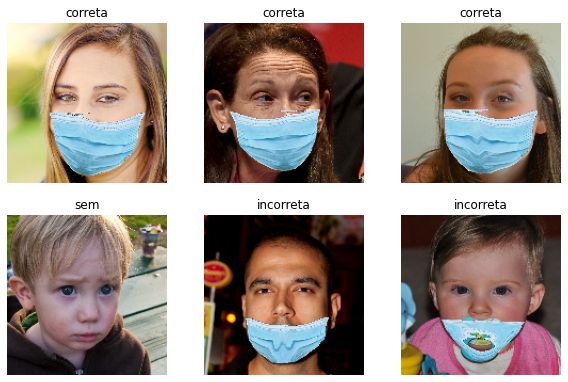

In [25]:
plotar_imagens(train_ds)

# Modelo

- HP do modelo

In [26]:
tx_aprendizagem = 0.0001
epocas = 50

- Podemos criar uma camada de normalização das imagens:

In [27]:
normalization_layer = tf.keras.layers.Rescaling(1./255, input_shape =image_shape)

- questão de cache das memórias

In [28]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Criação do modelo propriamente falando:

In [29]:
num_classes = 3

In [30]:
model = Sequential([
    normalization_layer,
    Conv2D(200, (3,3), activation='relu', input_shape=(image_width,image_height, image_color_channel)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(150, activation='relu'),
    Dense(num_classes, activation='softmax')    #sigmoid, softmax
])

In [31]:
#otimização
opt = Adam(learning_rate=tx_aprendizagem)

In [ ]:
#Poderiamos utilizar outras métricas:

# METRICS = [
#     tf.keras.metrics.Accuracy(name="acc"),
#     tf.keras.metrics.Precision(name="precision"),
#     tf.keras.metrics.Recall(name="recall"),
# ]

In [30]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='acc')   #METRICS)
model.summary()

#sparse_categorical_crossentropy ou 'categorical_crossentropy' na função perda


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 129600)            0

# Treinamento

- Treinando...

Existem várias maneiras de combater o overfitting no processo de treinamento, p.e.:
- o aumento de dados
- adicionará Dropout ao seu modelo.

- Cair fora
Outra técnica para reduzir o overfitting é introduzir a regularização de dropout na rede.

Quando você aplica dropout a uma camada, ela descarta aleatoriamente (definindo a ativação como zero) um número de unidades de saída da camada durante o processo de treinamento. Dropout recebe um número fracionário como valor de entrada, na forma de 0,1, 0,2, 0,4, etc. Isso significa descartar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

In [31]:
#Salvando o melhor modelo
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_accuracy',verbose=0,save_best_only=True,mode='auto')


#Treinando...
history = model.fit(train_ds,
                              epochs=epocas,
                              validation_data=val_ds,
                              callbacks=[checkpoint])

Epoch 1/50
583/583 [==============================] - 543s 887ms/step - loss: 0.0939 - acc: 0.9681 - val_loss: 0.0300 - val_acc: 0.9910
Epoch 2/50
583/583 [==============================] - 95s 163ms/step - loss: 0.0179 - acc: 0.9951 - val_loss: 0.0112 - val_acc: 0.9966
Epoch 3/50
583/583 [==============================] - 78s 134ms/step - loss: 0.0113 - acc: 0.9969 - val_loss: 0.0099 - val_acc: 0.9972
Epoch 4/50
583/583 [==============================] - 78s 134ms/step - loss: 0.0091 - acc: 0.9972 - val_loss: 0.0077 - val_acc: 0.9981
Epoch 5/50
583/583 [==============================] - 78s 135ms/step - loss: 0.0052 - acc: 0.9986 - val_loss: 0.0049 - val_acc: 0.9981
Epoch 6/50
583/583 [==============================] - 78s 134ms/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.0047 - val_acc: 0.9983
Epoch 7/50
583/583 [==============================] - 78s 134ms/step - loss: 0.0029 - acc: 0.9989 - val_loss: 0.0022 - val_acc: 0.9994
Epoch 8/50
583/583 [==============================] - 

In [32]:
#Plotar o desempenho
def processo_treinamento():
  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epocas)
  plt.gcf().clear()
  plt.figure(figsize = (15, 8))
  plt.subplot(1, 2, 1)
  plt.title('Evolução da Acurácia ao Longo do treinamento')
  plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
  plt.legend(loc = 'lower right')
  plt.subplot(1, 2, 2)
  plt.title('Evolução da Loss ao Longo do treinamento')
  plt.plot(epochs_range, loss, label = 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')
  plt.legend(loc = 'lower right')
  plt.savefig("processo-treinamento_normaliza_mod1.png", dpi=300)
  plt.show()
  

<Figure size 432x288 with 0 Axes>

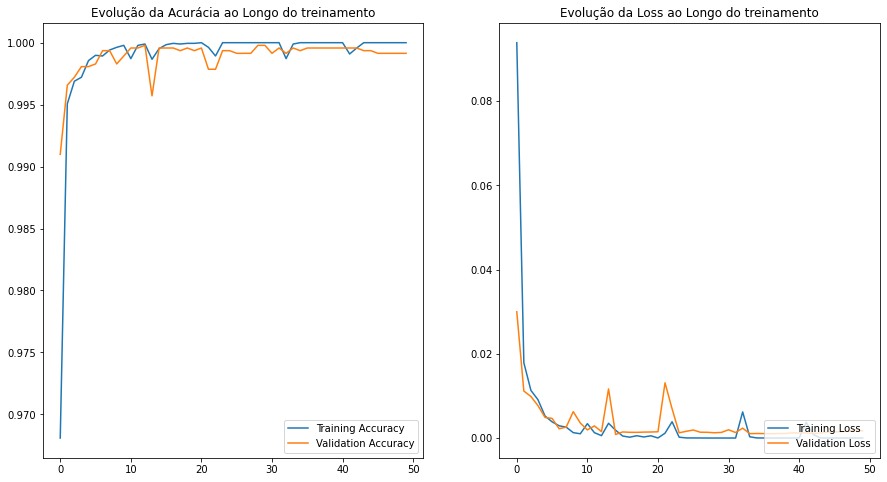

In [33]:
processo_treinamento()  

# Salvar o modelo

In [34]:
model.save('modelos/model_p1_normaliza')

INFO:tensorflow:Assets written to: model_p1_normaliza\assets


# Importando o modelo

- Perceba que se rodarmos o caderno do inicio ao fim, não seria necessário carregar o modelo, pois ele já estaria em memória.

In [35]:
model = load_model('modelos/model_p1_normaliza')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 129600)            0

### Aplicando o modelo a um dataset de teste

- Nosso dataset de teste, com imagens reais:

In [38]:
dataset_teste = os.path.join('D:/artigo/mix', '') 

In [39]:
data_dir_teste= pathlib.Path(dataset_teste)
data_dir_teste

WindowsPath('D:/artigo/mix')

In [108]:
image_count_t = len(list(data_dir_teste.glob('*/*')))   #ou .jpg
print(image_count_t)

97


In [109]:
list_t = tf.data.Dataset.list_files(str(data_dir_teste) + '/*/*', shuffle=False)
list_t = list_t.shuffle(image_count_t, reshuffle_each_iteration=False)

In [110]:
for f1 in list_t.take(3):
  print(f1.numpy())

b'D:\\artigo\\mix\\sem\\69013.png'
b'D:\\artigo\\mix\\sem\\69012.png'
b'D:\\artigo\\mix\\sem\\69015.png'


In [111]:
class_names = np.array(sorted([item.name for item in data_dir_1.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['correta' 'incorreta' 'sem']


In [112]:
val_size_t = int(image_count_t *0)
teste = list_t.skip(val_size_t)
print(tf.data.experimental.cardinality(teste).numpy())

97


In [113]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
teste  = teste.map(process_path, num_parallel_calls=AUTOTUNE)

In [114]:
for image, label in teste.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  0


In [115]:
#  Configurar conjunto de dados para desempenho
teste = configure_for_performance(teste)

#  questão de cache das memórias
teste =  teste.cache().prefetch(buffer_size=AUTOTUNE)

<Figure size 432x288 with 0 Axes>

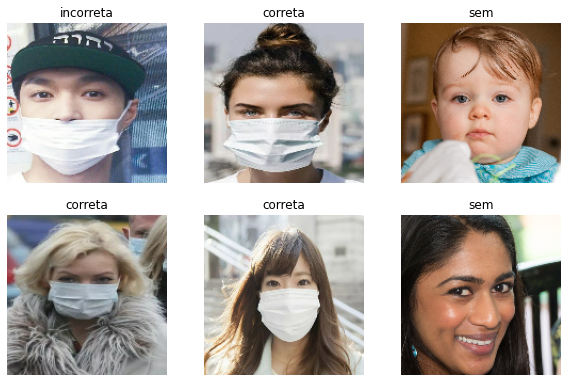

In [116]:
plotar_imagens(teste)

In [117]:
# Criando um dataframe

In [118]:
classe_real = pd.DataFrame(columns=["real"])
ponteiro = 0
for data in teste.as_numpy_iterator():
    a = class_names[data[1]]
    for i in range(a.size):  # de 0 a 31  
        classe_real.loc[i+ponteiro] = a[i]
    ponteiro= classe_real.shape[0]

In [119]:
classe_real

,real
0,incorreta
1,incorreta
2,incorreta
3,incorreta
4,incorreta
...,...
92,correta
93,correta
94,correta
95,incorreta


In [120]:
predictions = model.predict(teste)
print(predictions)

[[3.94029200e-08 3.84617364e-03 9.96153772e-01]
 [9.47866961e-03 8.83190811e-01 1.07330501e-01]
 [1.12051719e-08 3.60906488e-05 9.99963880e-01]
 [1.82891199e-05 5.51465809e-01 4.48515952e-01]
 [1.13063301e-07 3.62076634e-07 9.99999523e-01]
 [3.90859805e-06 1.30011132e-02 9.86994922e-01]
 [1.55783352e-03 1.05945989e-01 8.92496169e-01]
 [3.53095500e-04 2.97571514e-05 9.99617100e-01]
 [2.62658665e-04 1.67976206e-04 9.99569356e-01]
 [1.47219375e-14 1.24154237e-11 1.00000000e+00]
 [9.99943852e-01 5.61720553e-05 3.74047371e-09]
 [1.11968219e-02 1.49465069e-01 8.39338124e-01]
 [1.76564441e-15 2.72730814e-11 1.00000000e+00]
 [9.99983072e-01 1.69637478e-05 3.34051515e-12]
 [1.23068057e-11 2.08757400e-10 1.00000000e+00]
 [1.16143900e-12 6.71682820e-10 1.00000000e+00]
 [9.99614835e-01 3.85155261e-04 4.70097916e-09]
 [5.05757214e-10 1.03547704e-08 1.00000000e+00]
 [2.01380525e-14 6.10260109e-09 1.00000000e+00]
 [3.62084691e-08 4.63540055e-05 9.99953628e-01]
 [9.81897414e-01 1.99960545e-03 1.610296

In [121]:
def predicao(predictions):  #predictions é a saída da função predict
    score1 = tf.nn.softmax(predictions)    
    # score1.shape[0]  é a quantidade de predições
    classe = pd.DataFrame(columns=["predito","confianca"])
    for i in range(score1.shape[0]):
        classe.loc[i] = [class_names[np.argmax(score1[i])],100*np.max(score1[i])]   
    return classe

In [122]:
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
         return tf.concat(labels, axis=0) # concat the list of batched labels
    return class_names[labels]

In [123]:
get_labels_from_tfdataset(teste)

<tf.Tensor: shape=(97,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0,
       1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0,
       0, 2, 1, 2, 0, 0, 0, 1, 0], dtype=int64)>

In [124]:
classe_predita = predicao(predictions)
classe_predita

,predito,confianca
0,sem,57.470691
1,incorreta,53.256452
2,sem,57.610363
3,incorreta,40.350440
4,sem,57.611668
...,...,...
92,correta,57.570386
93,sem,57.611686
94,sem,47.991940
95,sem,57.611686


In [125]:
resultado_df = pd.concat([classe_real, classe_predita],axis=1)
resultado_df

,real,predito,confianca
0,incorreta,sem,57.470691
1,incorreta,incorreta,53.256452
2,incorreta,sem,57.610363
3,incorreta,incorreta,40.350440
4,incorreta,sem,57.611668
...,...,...,...
92,correta,correta,57.570386
93,correta,sem,57.611686
94,correta,sem,47.991940
95,incorreta,sem,57.611686


- Avaliação

In [61]:
model.evaluate(teste, return_dict=True)

5/5 [==============================] - 0s 40ms/step - loss: 6.3205 - acc: 0.5400


{'loss': 6.320502758026123, 'acc': 0.5400000214576721}

In [56]:
dataset_test_loss, dataset_test_accuracy = model.evaluate(teste)
print('Dataset Test Loss: %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

5/5 [==============================] - 0s 36ms/step - loss: 33.0125 - acc: 0.5933
Dataset Test Loss: 33.01247024536133
Dataset Test Accuracy: 0.5933333039283752


Obs.: Para as outras métricas, utilizar o arquivo avaliacao. Ele irá gerar uma matriz de confusão. Em seguida, com base nos elementos dessa matriz, ele realiza os cálculos das métricas